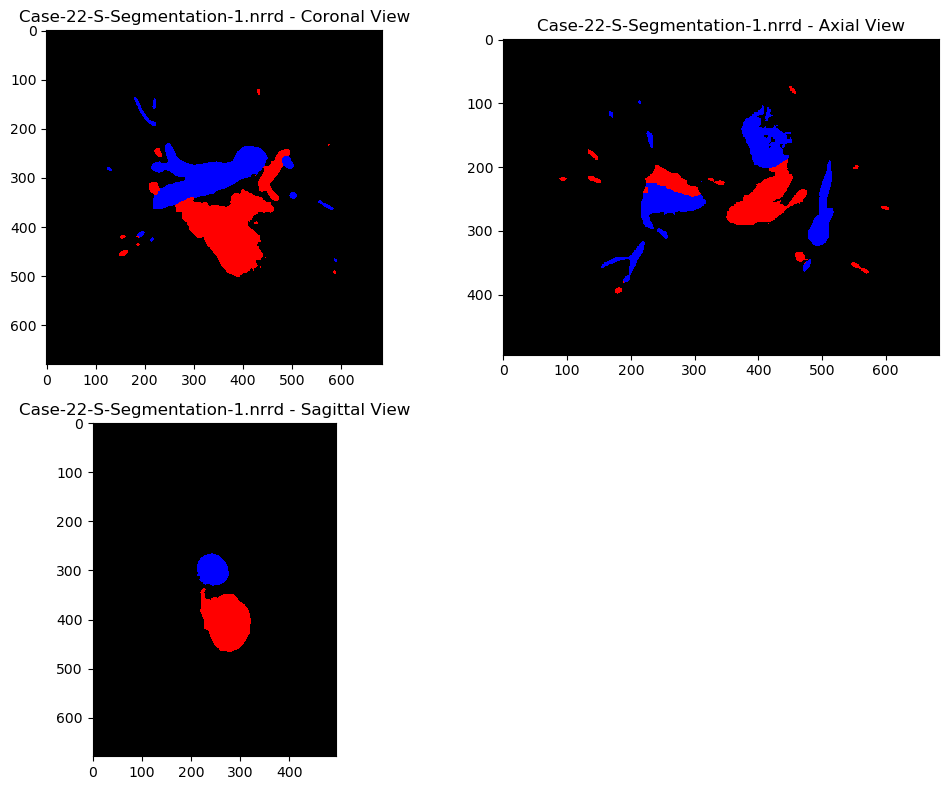

C:\Users\Adam\AppData\Local\Temp\ipykernel_14268\2979775853.py:92: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if   value == '0.847059 0.396078 0.309804':
C:\Users\Adam\AppData\Local\Temp\ipykernel_14268\2979775853.py:94: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif value == '0 0.592157 0.807843':


In [18]:
# [USE THIS - FUNCTIONAL]

import numpy as np
import nrrd
import matplotlib.pyplot as plt
import re
import os


# Load the .nrrd file
file_path = 'C:/Users/Adam/Desktop/Programs/code_testing/python_file_rename_copy/Case-22-0.5_A_80KV_Qr40d_3_53062428/MarkUps/88-Jensen/S-Segmentation-1.nrrd'
out_file = 'C:/Users/Adam/Desktop/Programs/code_testing/python_file_rename_copy/Case-22-0.5_A_80KV_Qr40d_3_53062428/MarkUps/88-Jensen/S-Segmentation-1_outputTest.nrrd'
data, header = nrrd.read(file_path)

#####################################################

# THIS SECTION IS USED TO GENERATE PLOTS OF THE CENTRAL AXIAL, CORONAL & SAGITTAL VIEWS OF THE INPUT FILE

# Calculate center indices for the three views
x_center = data.shape[0] // 2
y_center = data.shape[1] // 2
z_center = data.shape[2] // 2

# Rotates images to help match appearance in 3D Slicer
coronal_slice = np.rot90(data[:, y_center, :])
axial_slice = np.rot90(data[:, :, z_center])
sagittal_slice = np.rot90(data[x_center, :, :])

# Rotate the axial slice 180 degrees left to right to help match how it appears in 3D Slicer
axial_slice = np.flip(axial_slice, axis=0)

# Defines colors for segmentation values
colors = {
    0: (0, 0, 0),     # Black
    2: (0, 0, 255), # Blue
    1: (255, 0, 0),   # Red
}

# Applys colors to slices
def colorize_slice(slice_data):
    colored_slice = np.zeros(slice_data.shape + (3,), dtype=np.uint8)
    for value, color in colors.items():
        colored_slice[slice_data == value] = color
    return colored_slice

# Displays the slices
colored_coronal_slice = colorize_slice(coronal_slice)
colored_axial_slice = colorize_slice(axial_slice)
colored_sagittal_slice = colorize_slice(sagittal_slice)

# Creates a 2x2 subplot for the three views
plt.figure(figsize=(10, 8))

#######################################################

# Note: This code will not be needed for prepending 'Case-##' to the input file name in the plot title after adding 
    # this cell's function to the main copy/rename code

# Extract case number and following numbers from the path
match = re.search(r'Case-(\d+)', file_path)
if match:
    caseNum = match.group(1)

# Stores list of all numeric strings found in the current file path
numList = re.findall(r'\d+', file_path)

# Appends case number to 'Case-' string, used for finding the number of segmentation files for a given case #
caseAndNum = 'Case-' + caseNum

#######################################################

# Case number, file name, & the specific view is passed to the plot titles
plt.subplot(2, 2, 1)
plt.imshow(colored_coronal_slice, cmap='gray')
plt.title(caseAndNum + '-' + os.path.basename(file_path) + ' - Coronal View')

plt.subplot(2, 2, 2)
plt.imshow(colored_axial_slice, cmap='gray')
plt.title(caseAndNum + '-' + os.path.basename(file_path) + ' - Axial View')

plt.subplot(2, 2, 3)
plt.imshow(colored_sagittal_slice, cmap='gray')
plt.title(caseAndNum + '-' + os.path.basename(file_path) + ' - Sagittal View')

plt.tight_layout()
plt.show()

#######################################################

# Outputs header key/value list
for key, value in header.items():
    try:
        if   value == '0.847059 0.396078 0.309804': 
            VValue = header[key[0:-6] + '_LabelValue']
        elif value == '0 0.592157 0.807843': 
            AValue = header[key[0:-6] + '_LabelValue']
    except NameError:
        print("Expected segmentation volumes not found.")

# Creates new 3D numpy dataset, replaces values of 0 with 1 & 2 where they are present in the input file 
outputlabelmap = np.zeros_like(data)
outputlabelmap[np.equal(data, int(AValue))] = 1
outputlabelmap[np.equal(data, int(VValue))] = 2

# Saves segmentation to labelmap nrrd file
nrrd.write(out_file, outputlabelmap, header)


In [ ]:
import os
import re
import shutil
import numpy as np

# Input: list of inputs of 1 case aka list of 1 batch (could be NN = 2, 3, 11, etc)
# Input 2: single target label file (final)
# Input 3: list of other group's file paths (if 'files' is 'S-Final-' list, 'all_paths' is 'S-Segmentation-' list)
# Output: All NN input/output files copied
def process_files(files, new_dir, all_paths):

    for file_path in files:

        caseNum = ''
        # Get the base filename without the path
        original_name = os.path.basename(file_path)
        
        # Extract case number and following numbers from the path
        match = re.search(r'Case-(\d+)', file_path)
        if match:
            caseNum = match.group(1)
        
        # Stores list of all numeric strings found in the current file path
        numList = re.findall(r'\d+', file_path)
        
        # Appends case number to 'Case-' string, used for finding the number of segmentation files for a given case #
        caseAndNum = 'Case-' + caseNum

        # Initializes variables for 'if' statement
        new_filename = ""
        source_path = ""
        destination_path = ""
        new_label_filename = ""
        destination_label_path = ""

        # Gets segmentation file number
        pattern = r"S-Segmentation-(\d+)"
        numMatches = re.findall(pattern, original_name)

        # Checks the number of times 'Case-##' and 'S-Segmentation-' both appear in a string to determine how many copies of 'S-Final-' to make, and increment their number correctly
        count = 0
        for file in all_paths:
            # Could enforce .lowercase() when matching strings as a precaution
            if caseAndNum in file and "S-Segmentation-" in file:
                count += 1
                pattern = r"S-Segmentation-(\d+)"
                numMatches += re.findall(pattern, file)

        # Check if file name is 'final' or 'segmentation' to determine where to save the new copy
        if('S-Segmentation-' in original_name):
            # Construct the new filenames
            new_filename = f"Case-{caseNum}_{numList[np.argmax([len(x) for x in numList])]}_{numMatches[0]}.nrrd"
            #print("file_path: " + file_path)
            #print("new_filename: " + new_filename)
            # Construct the source paths for copying
            source_path = os.path.dirname(file_path + "/" + original_name).replace(os.path.sep, '/')
            #print("source_path: " + source_path)
            # Construct the destination paths for copying
            destination_path = os.path.join(new_dir, new_filename).replace(os.path.sep, '/')
            #print("destination_path: " + destination_path)


            try:
                shutil.copyfile(source_path, destination_path)
                print(f"Copied: {source_path} to {destination_path}")
            except PermissionError:
                print("Permission denied: Unable to copy the file.")

        elif('S-Final-' in original_name):
            
            # Checks if there is more than 1 S-Segmentation file associated with this labelmap for a given Case-##
            if(count>1):        
                
                # Creates as many copies of the labelmap file as there are S-Segmentation files for a given Case-##
                # NumMatches contains a list of the specific '#' in S-Segmentaion-# file numbers (Ex: '3' in S-Segmentaion-3)
                for i in range(count):
                    # Construct the new filenames
                    new_label_filename = f"Case-{caseNum}_{numList[np.argmax([len(x) for x in numList])]}_{numMatches[i]}.nrrd"
                    #print("original_name: " + new_label_filename)
                    #print("new_label_filename: " + new_label_filename)
                    # Construct the source paths for copying
                    source_path = os.path.dirname(file_path + "/" + original_name).replace(os.path.sep, '/')
                    #print("file_path: " + file_path)
                    #print("source_path: " + source_path)
                    # Construct the destination paths for copying
                    destination_label_path = os.path.join(new_dir, "labels", "final", new_label_filename).replace(os.path.sep, '/')
                    #print("destination_label_path: " + destination_label_path)

                    # Copy and rename the label file
                    try:
                        #with open(source_path, 'rb') as src, open(destination_label_path, 'wb') as dst:
                        #    shutil.copyfileobj(src, dst)
                        shutil.copyfile(source_path, destination_label_path)
                        #shutil.copy2(source_path, destination_label_path)
                        print(f"Copied: {source_path} to {destination_label_path}")
                    except PermissionError:
                        print("Permission denied: Unable to copy the file.")

        else:
            print("No match for 'S-Segmentaion-' or 'S-Final-' in path: " + file_path)
            continue
        
        #==========================================
        # Locate and copy the Vx3.nrrd file

        # vx3_source = os.path.join(source_path, "Vx3.nrrd")
        # vx3_destination = os.path.join(new_dir, f"Case-{caseNum}_{numList[np.argmax([len(x) for x in numList])]}_{original_name}_Vx3.nrrd")
        # shutil.copy(vx3_source, vx3_destination)
        # print(f"Copied: {vx3_source} to {vx3_destination}")
        #==========================================

final_files = []
#final_files1 = "C:\\Users\\Adam\\Desktop\\Programs\\code_testing\\python_file_rename_copy\\Case-22-0.5_A_80KV_Qr40d_3_53062428\\MarkUps\\88-Jensen\\S-Final-2-label.nrrd"
final_files1 = "C:/Users/Adam/Desktop/Programs/code_testing/python_file_rename_copy/Case-22-0.5_A_80KV_Qr40d_3_53062428/MarkUps/88-Jensen/S-Final-2-label.nrrd"
final_files2 = "C:/Users/Adam/Desktop/Programs/code_testing/python_file_rename_copy/Case-24-0.5__QR40__RESEARCH__M_0.6_Qr40d_3_51287502/Markups/88-Jensen/S-Final-2-label.nrrd"

final_files.append(final_files1)
final_files.append(final_files2)

# Segmentation files will be matched against the 'label' dataset from the same case
segmentation_files = []
seg_file1 = "C:/Users/Adam/Desktop/Programs/code_testing/python_file_rename_copy/Case-22-0.5_A_80KV_Qr40d_3_53062428/MarkUps/88-Jensen/S-Segmentation-1.nrrd"
seg_file2 = "C:/Users/Adam/Desktop/Programs/code_testing/python_file_rename_copy/Case-22-0.5_A_80KV_Qr40d_3_53062428/MarkUps/88-Jensen/S-Segmentation-2.nrrd"
seg_file3 = "C:/Users/Adam/Desktop/Programs/code_testing/python_file_rename_copy/Case-24-0.5__QR40__RESEARCH__M_0.6_Qr40d_3_51287502/Markups/88-Jensen/S-Segmentation-1.nrrd"
seg_file4 = "C:/Users/Adam/Desktop/Programs/code_testing/python_file_rename_copy/Case-24-0.5__QR40__RESEARCH__M_0.6_Qr40d_3_51287502/Markups/88-Jensen/S-Segmentation-2.nrrd"

segmentation_files.append(seg_file1)
segmentation_files.append(seg_file2)
segmentation_files.append(seg_file3)
segmentation_files.append(seg_file4)

new_dir = []
#new_dir1 = "C:\\Users\\Adam\\Desktop\\Programs\\code_testing\\python_file_rename_copy\\datasets"
new_dir1 = "C:/Users/Adam/Desktop/Programs/code_testing/python_file_rename_copy/datasets"

# Copy and rename 'label' files only
process_files(final_files, new_dir1, segmentation_files)

# Copy and rename 'segmentation' files only
process_files(segmentation_files, new_dir1, final_files)

